In [127]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [128]:

import re
import ast

def fully_robust_parser(s):
    if isinstance(s, list):
        return s  # Already parsed
    # Remove newlines and normalize spaces
    s = re.sub(r'\s+', ' ', s.strip())
    # Remove brackets temporarily
    s_clean = s.strip('[]')
    # Add a comma between numbers that are not separated by a comma (handles floats like '1. 0.8')
    s_clean = re.sub(r'(?<=[\d.]) (?=[\d.-])', ', ', s_clean)
    # Wrap again in brackets
    s_clean = f'[{s_clean}]'
    return ast.literal_eval(s_clean)


In [129]:
from scipy.stats import norm

def compute_ci(df, metric_name, alpha=0.05):
    z = norm.ppf(1 - alpha / 2)
    n = df[f"values_{metric_name}"].apply(len)

    confidence_level = 1-alpha

    margin = z * df[f"std_{metric_name}"] / np.sqrt(n)

    avg = df[f"avg_{metric_name}"]
    std = df[f"std_{metric_name}"]

    df[f"ci_upper_{metric_name}"] = df[f"avg_{metric_name}"] + margin

    results_df = df[["method", "model", "benchmark", "evaluator"]]
    results_df["metric"] = metric_name
    results_df["avg"] = avg
    results_df["std"] = std
    # results_df["ci_lower"] = avg - margin
    # results_df["ci_upper"] = avg + margin
    results_df["ci_error"] = margin
    results_df["n"] = n
    results_df["confidence_level"] = confidence_level
    
    return results_df

In [130]:


def multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map):  
    # Load and process each dataframe
    processed_dfs = []
    for eval_run_id in eval_run_ids:
        results_path = Path("../../results") / project_name / "aggregated_results" / eval_run_id / f"evaluation_{eval_run_id}.csv"
        df = pd.read_csv(results_path)
        
        # Apply method mapping
        df["method"] = df["method"].replace(method_map)
        
        # Process each available metric
        metric_results = []
        for metric in all_metrics:
            required_cols = [f"values_{metric}", f"std_{metric}", f"avg_{metric}"]
            if all(col in df.columns for col in required_cols):
                # Parse values
                df[f"values_{metric}"] = df[f"values_{metric}"].apply(fully_robust_parser)
                
                # Compute confidence intervals
                result_df = compute_ci(df, metric, alpha=0.05)
                
                # Add source column
                result_df["source"] = eval_run_id
                
                metric_results.append(result_df)
        
        if metric_results:
            # Combine all metrics for this source
            source_df = pd.concat(metric_results, ignore_index=True)
            processed_dfs.append(source_df)

    # Combine all processed dataframes
    if processed_dfs:
        combined_df = pd.concat(processed_dfs, ignore_index=True)
        
        # Create a unique identifier for each metric-source combination
        combined_df["metric_source"] = combined_df["metric"] + "_" + combined_df["source"]
        
        # Convert method and model to categorical with specified order
        combined_df["method"] = pd.Categorical(combined_df["method"], categories=method_order, ordered=True)
        combined_df["model"] = pd.Categorical(combined_df["model"], categories=model_order, ordered=True)
        
        # Sort the dataframe before pivoting to ensure order is preserved
        combined_df = combined_df.sort_values(["method", "model"])
        
        # Pivot to get metrics from different sources as separate columns
        pivoted_df = combined_df.pivot_table(
            index=["method", "model"],
            columns="metric_source",
            values=["avg", "ci_error"]
        )
        
        # Flatten column names
        pivoted_df.columns = [f"{stat}_{col}" for stat, col in pivoted_df.columns]
        
        # Reset index to get a regular dataframe
        final_df = pivoted_df.reset_index()
        
        # Ensure the categorical order is preserved after reset_index
        final_df["method"] = pd.Categorical(final_df["method"], categories=method_order, ordered=True)
        final_df["model"] = pd.Categorical(final_df["model"], categories=model_order, ordered=True)
        
        # Sort the final dataframe
        final_df = final_df.sort_values(["method", "model"])
        
        print(f"Successfully created merged dataframe with {len(final_df)} rows")
        print(f"Columns in final dataframe: {final_df.columns.tolist()}")
        
        return final_df
        
        # Now you can use final_df for your analysis
    else:
        print("No data to process - check your dataframes")

In [131]:
project_name = "malicious_instruct"
# project_name = "jailbreaks_small_v1"

eval_run_ids = [
    "qwen7B-v2",
    "baseline",
]

# eval_run_ids = [
#     "basline_6x5",
#     "qwen7B-v2",

# ]

# Define all possible metrics
all_metrics = ["refusal", "attempt", "useful", "gen_time"]

# Define the order for methods and models
METHOD_1 = "Baseline"
METHOD_2 = "Prefix Injection"
METHOD_3 = "Ablation"
METHOD_4 = "Ablation + Prefix Injection"
METHOD_5 = "Output Aware"

method_map = {
    "baseline": METHOD_1,
    "prefixinjection-3": METHOD_2,
    "diffinmeans": METHOD_3,
    "diffinmeans_prefixinjection-3": METHOD_4,
    "outputaware": METHOD_5,
}

method_order = [
    METHOD_1,
    METHOD_2,
    METHOD_3,
    METHOD_4,
    #METHOD_5,
]

model_order = [
    "Qwen2-0.5B-Instruct",
    "Qwen2.5-1.5B-Instruct",
    "Qwen2.5-3B-Instruct",
    "Qwen2.5-7B-Instruct",
    "Llama-3.1-8B-Instruct",
    "Mistral-7B-Instruct-v0.1"
]

df = multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map)

Successfully created merged dataframe with 24 rows
Columns in final dataframe: ['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_baseline', 'avg_gen_time_qwen7B-v2', 'avg_refusal_baseline', 'avg_refusal_qwen7B-v2', 'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2', 'ci_error_gen_time_baseline', 'ci_error_gen_time_qwen7B-v2', 'ci_error_refusal_baseline', 'ci_error_refusal_qwen7B-v2', 'ci_error_useful_qwen7B-v2']


/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["metric"] = metric_name
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["avg"] = avg
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [132]:
def invert_metrics(df, metrics_to_invert=["refusal"]):
    # Create a copy of the dataframe to avoid modifying the original
    inverted_df = df.copy()
    
    # Find all columns related to the metrics to invert
    for metric in metrics_to_invert:
        # Find average columns for this metric
        avg_cols = [col for col in df.columns if col.startswith(f"avg_{metric}")]
        
        # Invert each average column (1 - value)
        for avg_col in avg_cols:
            inverted_df[avg_col] = 1 - df[avg_col]
            
            # Rename the column to indicate it's been inverted
            #new_col_name = avg_col.replace(f"avg_{metric}", f"avg_{metric}_inverted")
            #inverted_df = inverted_df.rename(columns={avg_col: new_col_name})
    
    return inverted_df

In [133]:
inverted = invert_metrics(df, metrics_to_invert=["refusal"])

In [134]:
inverted

,method,model,avg_attempt_qwen7B-v2,avg_gen_time_baseline,avg_gen_time_qwen7B-v2,avg_refusal_baseline,avg_refusal_qwen7B-v2,avg_useful_qwen7B-v2,ci_error_attempt_qwen7B-v2,ci_error_gen_time_baseline,ci_error_gen_time_qwen7B-v2,ci_error_refusal_baseline,ci_error_refusal_qwen7B-v2,ci_error_useful_qwen7B-v2
0,Baseline,Qwen2-0.5B-Instruct,0.404,0.109216,0.109216,0.330,0.378,0.026,0.046580,0.021717,0.021717,0.035496,0.030565,0.010518
1,Baseline,Qwen2.5-1.5B-Instruct,0.226,0.124257,0.124257,0.210,0.216,0.032,0.026354,0.024299,0.024299,0.024164,0.026931,0.006559
2,Baseline,Qwen2.5-3B-Instruct,0.932,0.155908,0.155908,0.192,0.260,0.424,0.027939,0.031809,0.031809,0.016067,0.019988,0.037022
3,Baseline,Qwen2.5-7B-Instruct,0.998,0.126445,0.126445,0.248,0.374,0.478,0.003506,0.025487,0.025487,0.021755,0.014242,0.027939
4,Baseline,Llama-3.1-8B-Instruct,0.538,0.132370,0.132370,0.884,0.038,0.038,0.039744,0.028288,0.028288,0.022586,0.003506,0.012882
5,Baseline,Mistral-7B-Instruct-v0.1,1.000,0.134780,0.134780,1.000,1.000,0.046,0.000000,0.027983,0.027983,0.000000,0.000000,0.004294
6,Prefix Injection,Qwen2-0.5B-Instruct,0.996,0.113766,0.113766,0.976,0.996,0.008,0.004294,0.021429,0.021429,0.011890,0.004294,0.010222
7,Prefix Injection,Qwen2.5-1.5B-Instruct,0.814,0.124928,0.124928,0.684,0.730,0.034,0.020444,0.024552,0.024552,0.028591,0.021470,0.013119
8,Prefix Injection,Qwen2.5-3B-Instruct,1.000,0.155851,0.155851,0.986,1.000,0.030,0.000000,0.031491,0.031491,0.008939,0.000000,0.005544
9,Prefix Injection,Qwen2.5-7B-Instruct,1.000,0.129088,0.129088,0.942,0.984,0.074,0.000000,0.025471,0.025471,0.010222,0.010518,0.022586


In [135]:
def rename_source_in_columns(df, old_source, new_source):
    renamed_columns = {col: col.replace(old_source, new_source) for col in df.columns if old_source in col}
    return df.rename(columns=renamed_columns)


In [136]:
import os
import pandas as pd
from pathlib import Path

def save_all_metrics_formatted_table(df, metrics, sources, output_path):
    """
    Format a dataframe with mean ± ci_error for all specified metrics and save as CSV
    
    Args:
        df: The dataframe from multi_evaluator_table
        metrics: List of metrics to extract (e.g., ["attempt", "refusal"])
        sources: List of sources (e.g., ["qwen7B-v2", "baseline"])
        output_path: Path to save the CSV file
    """
    # Create a new dataframe with method and model columns
    formatted_df = df[["method", "model"]].copy()
    
    # For each metric and source combination
    for metric in metrics:
        for source in sources:
            # Find the corresponding average and ci_error columns
            avg_col = f"avg_{metric}_{source}"
            ci_col = f"ci_error_{metric}_{source}"
            
            # Check if both columns exist in the dataframe
            if avg_col in df.columns and ci_col in df.columns:
                # Format the values as "mean ± ci_error" with 3 decimal places
                col_name = f"{metric}_{source}"
                if "gen_time" in metric:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[avg_col]*100:.0f} ± {row[ci_col]*100:.0f}", 
                        axis=1
                    )
                else:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[avg_col]*100:.1f}% ± {row[ci_col]*100:.1f}%", 
                        axis=1
                    )
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save to CSV
    formatted_df.to_csv(output_path, index=False)
    print(f"Saved formatted table to {output_path}")
    
    return formatted_df

# Example usage:
# Get the dataframe from multi_evaluator_table
df = multi_evaluator_table(project_name, eval_run_ids, method_order, model_order, all_metrics, method_map)

df = invert_metrics(df, metrics_to_invert=["refusal"])

df = rename_source_in_columns(df, "refusal", "ASR")

metrics_for_table = [metric.replace("refusal", "ASR") if metric == "refusal" else metric for metric in all_metrics]

# Format and save the table with all metrics
output_path = 'results/tables/all_metrics_table.csv'
formatted_df = save_all_metrics_formatted_table(
    df, 
    metrics=metrics_for_table,
    sources=eval_run_ids,
    output_path=output_path
)

# Display the formatted dataframe
formatted_df

Successfully created merged dataframe with 24 rows
Columns in final dataframe: ['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_baseline', 'avg_gen_time_qwen7B-v2', 'avg_refusal_baseline', 'avg_refusal_qwen7B-v2', 'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2', 'ci_error_gen_time_baseline', 'ci_error_gen_time_qwen7B-v2', 'ci_error_refusal_baseline', 'ci_error_refusal_qwen7B-v2', 'ci_error_useful_qwen7B-v2']
Saved formatted table to results/tables/all_metrics_table.csv


/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["metric"] = metric_name
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["avg"] = avg
/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/743571259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,method,model,ASR_qwen7B-v2,ASR_baseline,attempt_qwen7B-v2,useful_qwen7B-v2,gen_time_qwen7B-v2,gen_time_baseline
0,Baseline,Qwen2-0.5B-Instruct,37.8% ± 3.1%,33.0% ± 3.5%,40.4% ± 4.7%,2.6% ± 1.1%,11 ± 2,11 ± 2
1,Baseline,Qwen2.5-1.5B-Instruct,21.6% ± 2.7%,21.0% ± 2.4%,22.6% ± 2.6%,3.2% ± 0.7%,12 ± 2,12 ± 2
2,Baseline,Qwen2.5-3B-Instruct,26.0% ± 2.0%,19.2% ± 1.6%,93.2% ± 2.8%,42.4% ± 3.7%,16 ± 3,16 ± 3
3,Baseline,Qwen2.5-7B-Instruct,37.4% ± 1.4%,24.8% ± 2.2%,99.8% ± 0.4%,47.8% ± 2.8%,13 ± 3,13 ± 3
4,Baseline,Llama-3.1-8B-Instruct,3.8% ± 0.4%,88.4% ± 2.3%,53.8% ± 4.0%,3.8% ± 1.3%,13 ± 3,13 ± 3
5,Baseline,Mistral-7B-Instruct-v0.1,100.0% ± 0.0%,100.0% ± 0.0%,100.0% ± 0.0%,4.6% ± 0.4%,13 ± 3,13 ± 3
6,Prefix Injection,Qwen2-0.5B-Instruct,99.6% ± 0.4%,97.6% ± 1.2%,99.6% ± 0.4%,0.8% ± 1.0%,11 ± 2,11 ± 2
7,Prefix Injection,Qwen2.5-1.5B-Instruct,73.0% ± 2.1%,68.4% ± 2.9%,81.4% ± 2.0%,3.4% ± 1.3%,12 ± 2,12 ± 2
8,Prefix Injection,Qwen2.5-3B-Instruct,100.0% ± 0.0%,98.6% ± 0.9%,100.0% ± 0.0%,3.0% ± 0.6%,16 ± 3,16 ± 3
9,Prefix Injection,Qwen2.5-7B-Instruct,98.4% ± 1.1%,94.2% ± 1.0%,100.0% ± 0.0%,7.4% ± 2.3%,13 ± 3,13 ± 3


In [137]:

def rename_models(df):
    # Create a copy to avoid modifying the original
    df_renamed = df.copy()
    col = "model"
    
    # Define model name mappings (add more as needed)
    model_mapping = {
        'Qwen2-0.5B-Instruct': 'Qwen2.0-0.5B',
        'Qwen2.5-1.5B-Instruct': 'Qwen2.5-1.5B',
        'Qwen2.5-3B-Instruct': 'Qwen2.5-3B',
        'Qwen2.5-7B-Instruct': 'Qwen2.5-7B',
        'Llama-3.1-8B-Instruct': 'Llama-3.1-8B',
        'Mistral-7B-Instruct-v0.1': 'Mistral-v0.1-7B',
    }
    
    # Apply the renaming if the Model column exists
    if col in df_renamed.columns:
        df_renamed[col] = df_renamed[col].replace(model_mapping)
    
    return df_renamed

df = rename_models(df)

/var/folders/qk/chlqbgnn41b0wjghf601kjxm0000gn/T/ipykernel_44434/1738676065.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_renamed[col] = df_renamed[col].replace(model_mapping)


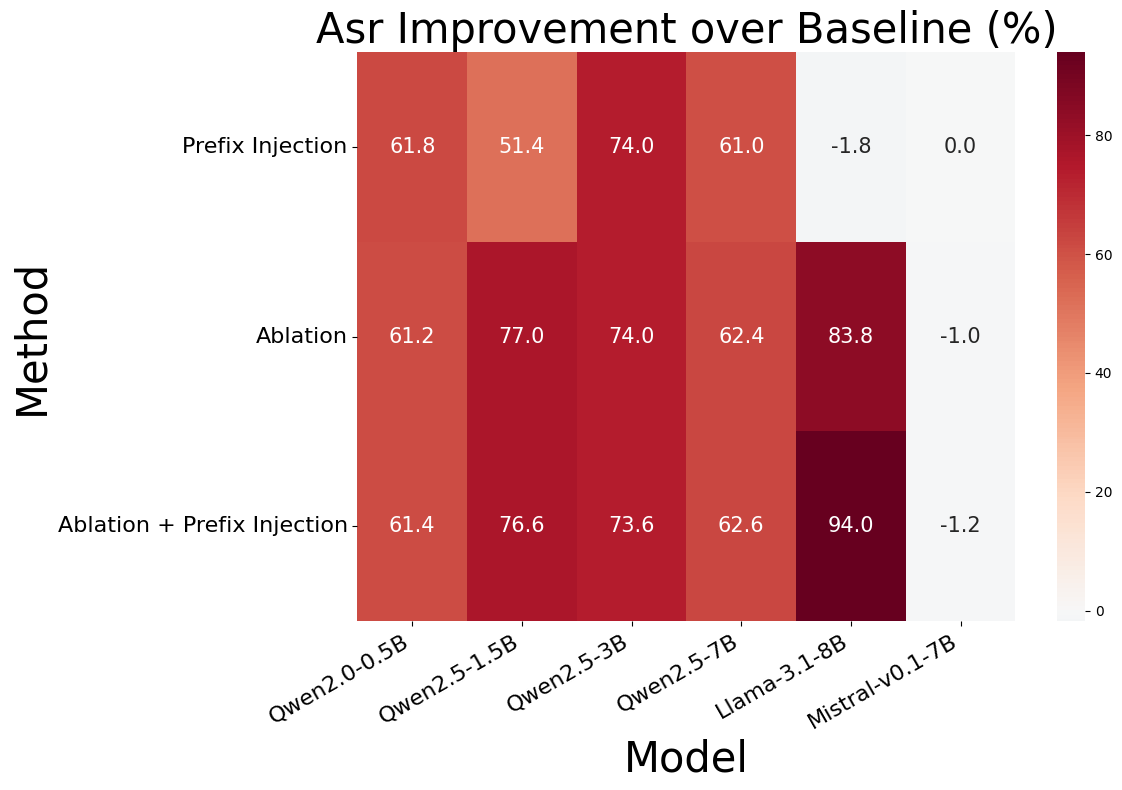

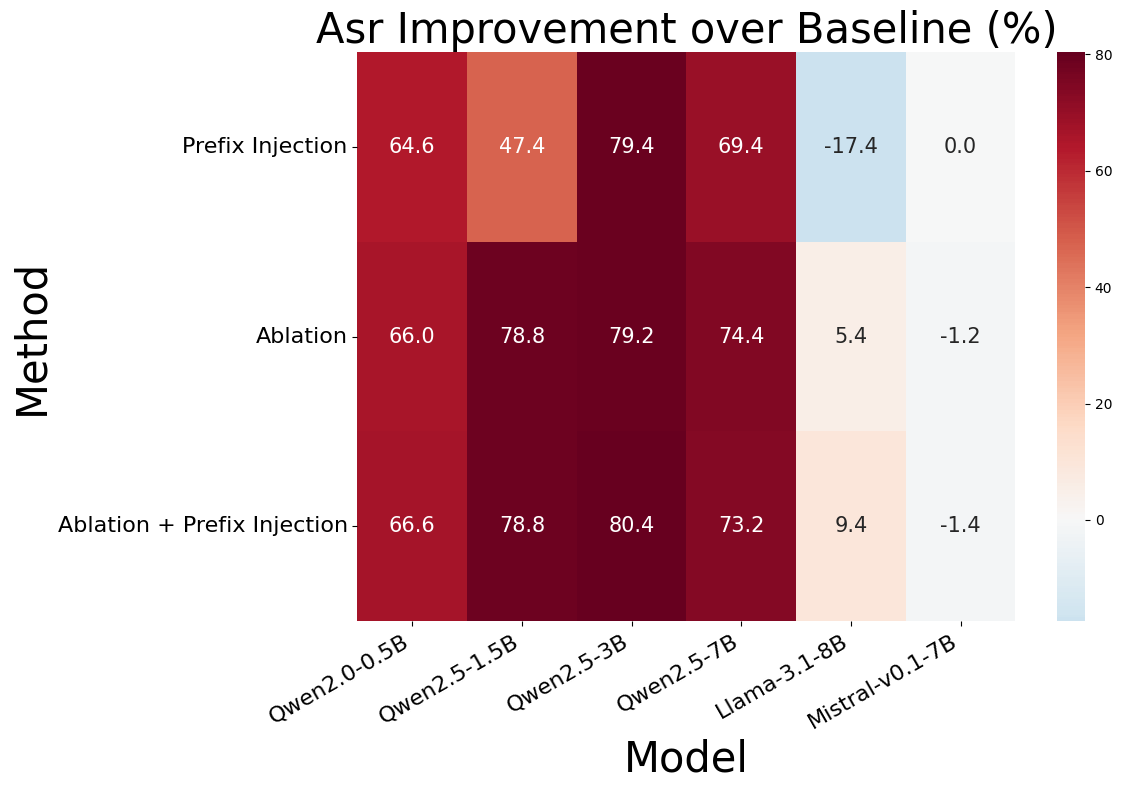

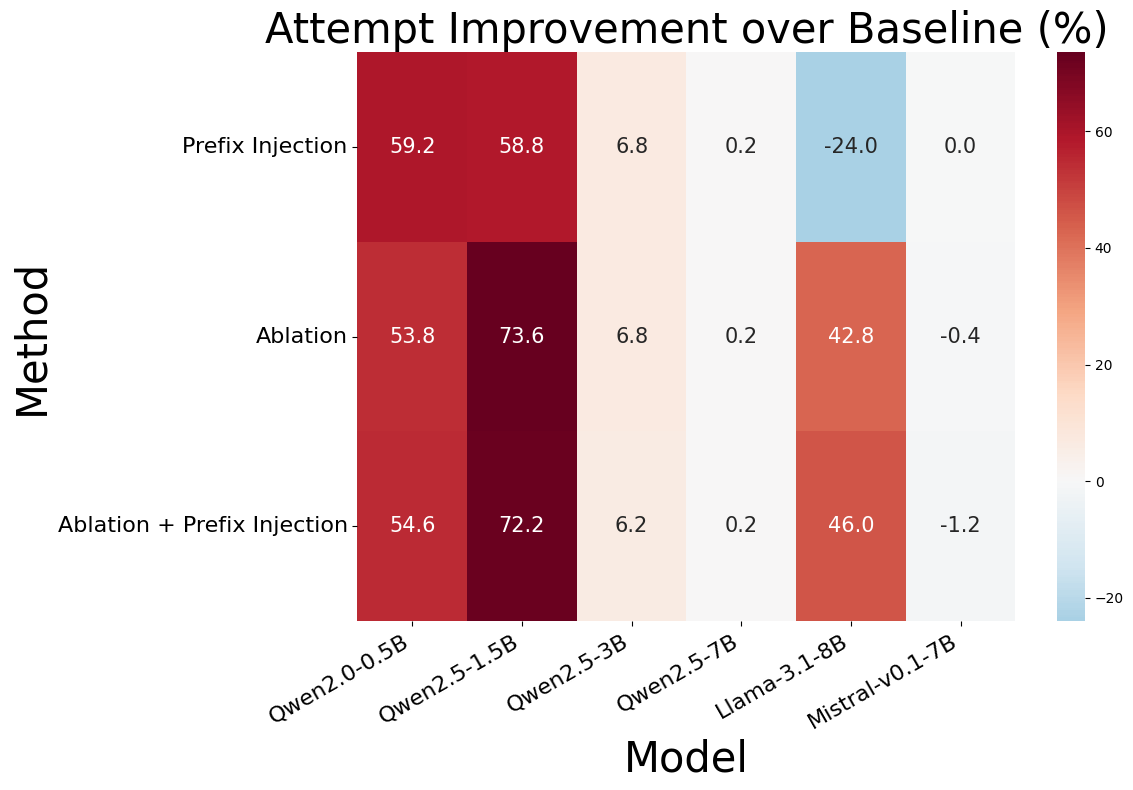

Column dev_attempt_baseline not found in dataframe. Available columns: Index(['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_baseline',
       'avg_gen_time_qwen7B-v2', 'avg_ASR_baseline', 'avg_ASR_qwen7B-v2',
       'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2',
       'ci_error_gen_time_baseline', 'ci_error_gen_time_qwen7B-v2',
       'ci_error_ASR_baseline', 'ci_error_ASR_qwen7B-v2',
       'ci_error_useful_qwen7B-v2', 'dev_ASR_baseline', 'dev_std_ASR_baseline',
       'dev_ASR_qwen7B-v2', 'dev_std_ASR_qwen7B-v2', 'dev_attempt_qwen7B-v2',
       'dev_std_attempt_qwen7B-v2', 'dev_useful_qwen7B-v2',
       'dev_std_useful_qwen7B-v2', 'dev_gen_time_baseline',
       'dev_std_gen_time_baseline', 'dev_gen_time_qwen7B-v2',
       'dev_std_gen_time_qwen7B-v2'],
      dtype='object')


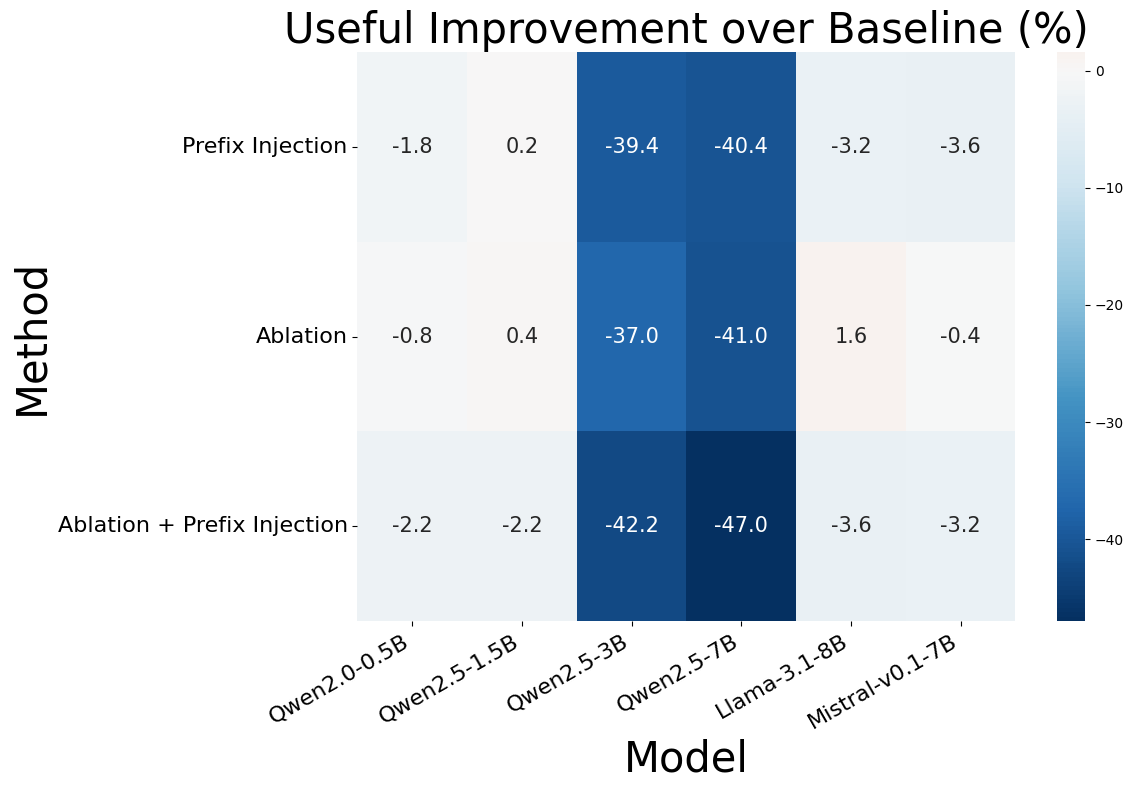

Column dev_useful_baseline not found in dataframe. Available columns: Index(['method', 'model', 'avg_attempt_qwen7B-v2', 'avg_gen_time_baseline',
       'avg_gen_time_qwen7B-v2', 'avg_ASR_baseline', 'avg_ASR_qwen7B-v2',
       'avg_useful_qwen7B-v2', 'ci_error_attempt_qwen7B-v2',
       'ci_error_gen_time_baseline', 'ci_error_gen_time_qwen7B-v2',
       'ci_error_ASR_baseline', 'ci_error_ASR_qwen7B-v2',
       'ci_error_useful_qwen7B-v2', 'dev_ASR_baseline', 'dev_std_ASR_baseline',
       'dev_ASR_qwen7B-v2', 'dev_std_ASR_qwen7B-v2', 'dev_attempt_qwen7B-v2',
       'dev_std_attempt_qwen7B-v2', 'dev_useful_qwen7B-v2',
       'dev_std_useful_qwen7B-v2', 'dev_gen_time_baseline',
       'dev_std_gen_time_baseline', 'dev_gen_time_qwen7B-v2',
       'dev_std_gen_time_qwen7B-v2'],
      dtype='object')
Saved deviance dataframe to results/tables/deviance_from_baseline.csv
Saved formatted deviance table to results/tables/deviance_formatted_table.csv


,method,model,ASR_dev_qwen7B-v2,ASR_dev_baseline,attempt_dev_qwen7B-v2,useful_dev_qwen7B-v2,gen_time_dev_qwen7B-v2,gen_time_dev_baseline
0,Baseline,Qwen2.0-0.5B,0.0% ± 4.3%,0.0% ± 5.0%,0.0% ± 6.6%,0.0% ± 1.5%,0.0 ± 0.0,0.0 ± 0.0
1,Baseline,Qwen2.5-1.5B,0.0% ± 3.8%,0.0% ± 3.4%,0.0% ± 3.7%,0.0% ± 0.9%,0.0 ± 0.0,0.0 ± 0.0
2,Baseline,Qwen2.5-3B,0.0% ± 2.8%,0.0% ± 2.3%,0.0% ± 4.0%,0.0% ± 5.2%,0.0 ± 0.0,0.0 ± 0.0
3,Baseline,Qwen2.5-7B,0.0% ± 2.0%,0.0% ± 3.1%,0.0% ± 0.5%,0.0% ± 4.0%,0.0 ± 0.0,0.0 ± 0.0
4,Baseline,Llama-3.1-8B,0.0% ± 0.5%,0.0% ± 3.2%,0.0% ± 5.6%,0.0% ± 1.8%,0.0 ± 0.0,0.0 ± 0.0
5,Baseline,Mistral-v0.1-7B,0.0% ± 0.0%,0.0% ± 0.0%,0.0% ± 0.0%,0.0% ± 0.6%,0.0 ± 0.0,0.0 ± 0.0
6,Prefix Injection,Qwen2.0-0.5B,61.8% ± 3.1%,64.6% ± 3.7%,59.2% ± 4.7%,-1.8% ± 1.5%,0.0 ± 0.0,0.0 ± 0.0
7,Prefix Injection,Qwen2.5-1.5B,51.4% ± 3.4%,47.4% ± 3.7%,58.8% ± 3.3%,0.2% ± 1.5%,0.0 ± 0.0,0.0 ± 0.0
8,Prefix Injection,Qwen2.5-3B,74.0% ± 2.0%,79.4% ± 1.8%,6.8% ± 2.8%,-39.4% ± 3.7%,-0.0 ± 0.0,-0.0 ± 0.0
9,Prefix Injection,Qwen2.5-7B,61.0% ± 1.8%,69.4% ± 2.4%,0.2% ± 0.4%,-40.4% ± 3.6%,0.0 ± 0.0,0.0 ± 0.0


In [138]:
import os
def calculate_deviance_from_baseline(df, metrics, baseline_method=METHOD_1):
    """
    Calculate the deviance of each method from the baseline method for each metric and model.
    
    Args:
        df: DataFrame from multi_evaluator_table
        metrics: List of metrics to calculate deviance for
        baseline_method: The method to use as baseline (default: METHOD_1)
        
    Returns:
        DataFrame with deviance values
    """
    # Create a copy of the dataframe
    deviance_df = df.copy()
    
    # Get all unique models
    models = df['model'].unique()
    
    # For each metric, calculate deviance from baseline
    for metric in metrics:
        # Find all average columns for this metric
        avg_cols = [col for col in df.columns if col.startswith(f"avg_{metric}")]
        std_cols = [col for col in df.columns if col.startswith(f"ci_error_{metric}")]
        
        for avg_col, std_col in zip(avg_cols, std_cols):
            # Create new column names for deviance
            dev_col = avg_col.replace("avg_", "dev_")
            dev_std_col = std_col.replace("ci_error_", "dev_std_")
            
            # Initialize the deviance columns with NaN
            deviance_df[dev_col] = np.nan
            deviance_df[dev_std_col] = np.nan
            
            # For each model, calculate deviance from baseline
            for model in models:
                # Get the baseline value for this model
                baseline_value = df[(df['method'] == baseline_method) & 
                                   (df['model'] == model)][avg_col].values
                
                baseline_std = df[(df['method'] == baseline_method) & 
                                 (df['model'] == model)][std_col].values
                
                if len(baseline_value) > 0:
                    baseline_value = baseline_value[0]
                    baseline_std = baseline_std[0]
                    
                    # Calculate deviance for each method for this model
                    model_mask = deviance_df['model'] == model
                    deviance_df.loc[model_mask, dev_col] = deviance_df.loc[model_mask, avg_col] - baseline_value
                    
                    # Propagate error (sqrt of sum of squares for independent errors)
                    deviance_df.loc[model_mask, dev_std_col] = np.sqrt(
                        deviance_df.loc[model_mask, std_col]**2 + baseline_std**2
                    )
    
    return deviance_df

def create_deviance_heatmap(df, metric, source, title=None, cmap="RdBu_r", figsize=(12, 8), 
                           center=0, vmin=None, vmax=None, annot=True, fmt=".1f", 
                           annot_kws=None, xlabel=None, ylabel=None, 
                           xlabel_fontsize=12, ylabel_fontsize=12, fontsize=12):
    """
    Create a heatmap showing deviance from baseline for a specific metric and source.
    
    Args:
        df: DataFrame with deviance values
        metric: Metric name (e.g., "ASR", "attempt", "useful")
        source: Source name (e.g., "basline_6x5")
        title: Optional title for the heatmap
        cmap: Colormap to use (default: RdBu_r for diverging data)
        figsize: Figure size as (width, height)
        center: Center value for diverging colormap
        vmin, vmax: Min and max values for color scaling
        annot: Whether to annotate cells
        fmt: Format string for annotations
        annot_kws: Additional kwargs for annotations
    """
    # Extract the deviance values for the specified metric and source
    dev_col = f"dev_{metric}_{source}"
    
    if dev_col not in df.columns:
        print(f"Column {dev_col} not found in dataframe. Available columns: {df.columns}")
        return
    
    # Filter out the baseline method as it will always have zero deviance
    plot_df = df[df['method'] != METHOD_1].copy()
    
    # Pivot the data to create a matrix suitable for heatmap
    pivot_df = plot_df.pivot(index="method", columns="model", values=dev_col)
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set default annotation parameters if not provided
    if annot_kws is None:
        annot_kws = {"size": 15}
    
    # Create the heatmap
    if metric == "gen_time":
        # For generation time, don't use percentage format
        sns.heatmap(pivot_df, annot=annot, fmt=fmt, cmap=cmap, center=center,
                    vmin=vmin, vmax=vmax, annot_kws=annot_kws, ax=ax)
    else:
        # For percentage metrics, multiply by 100 and use percentage format
        sns.heatmap(pivot_df * 100, annot=annot, fmt=fmt, cmap=cmap, center=center,
                    vmin=vmin, vmax=vmax, annot_kws=annot_kws, ax=ax)
    
    # Set title if provided
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f"{metric.capitalize()} Deviance from Baseline", fontsize=fontsize)
    
    # Set custom axis labels if provided
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30, ha="right", fontsize=16)
    plt.yticks(rotation=0, ha="right", fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    
    return ax

# Example usage:
# Calculate deviance from baseline for all metrics
metrics_for_deviance = [metric.replace("refusal", "ASR") if metric == "refusal" else metric 
                       for metric in all_metrics]

deviance_df = calculate_deviance_from_baseline(df, metrics_for_deviance, baseline_method=METHOD_1)

# Create deviance heatmaps for each metric
for metric in metrics_for_deviance:
    if metric != "gen_time":  # Skip generation time if you don't want to show it
        for source in eval_run_ids:
            create_deviance_heatmap(
                deviance_df, 
                metric=metric, 
                source=source,
                title=f"{metric.capitalize()} Improvement over Baseline (%)",
                cmap="RdBu_r",  # Red-Blue diverging colormap
                xlabel="Model",
                ylabel="Method",
                ylabel_fontsize=30,
                xlabel_fontsize=30,
                fontsize=30
            )
            plt.show()

# Save the deviance dataframe to CSV
output_path = 'results/tables/deviance_from_baseline.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
deviance_df.to_csv(output_path, index=False)
print(f"Saved deviance dataframe to {output_path}")

# Create a formatted table with deviance values
def save_deviance_formatted_table(df, metrics, sources, output_path):
    """
    Format a dataframe with deviance ± std for all specified metrics and save as CSV
    """
    # Create a new dataframe with method and model columns
    formatted_df = df[["method", "model"]].copy()
    
    # For each metric and source combination
    for metric in metrics:
        for source in sources:
            # Find the corresponding deviance and std columns
            dev_col = f"dev_{metric}_{source}"
            std_col = f"dev_std_{metric}_{source}"
            
            # Check if both columns exist in the dataframe
            if dev_col in df.columns and std_col in df.columns:
                # Format the values as "deviance ± std" with 1 decimal place
                col_name = f"{metric}_dev_{source}"
                if "gen_time" in metric:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[dev_col]:.1f} ± {row[std_col]:.1f}", 
                        axis=1
                    )
                else:
                    formatted_df[col_name] = df.apply(
                        lambda row: f"{row[dev_col]*100:.1f}% ± {row[std_col]*100:.1f}%", 
                        axis=1
                    )
    
    # Save to CSV
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    formatted_df.to_csv(output_path, index=False)
    print(f"Saved formatted deviance table to {output_path}")
    
    return formatted_df

# Format and save the deviance table
output_path = 'results/tables/deviance_formatted_table.csv'
formatted_deviance_df = save_deviance_formatted_table(
    deviance_df, 
    metrics=metrics_for_deviance,
    sources=eval_run_ids,
    output_path=output_path
)

# Display the formatted deviance dataframe
formatted_deviance_df

In [139]:
df

,method,model,avg_attempt_qwen7B-v2,avg_gen_time_baseline,avg_gen_time_qwen7B-v2,avg_ASR_baseline,avg_ASR_qwen7B-v2,avg_useful_qwen7B-v2,ci_error_attempt_qwen7B-v2,ci_error_gen_time_baseline,ci_error_gen_time_qwen7B-v2,ci_error_ASR_baseline,ci_error_ASR_qwen7B-v2,ci_error_useful_qwen7B-v2
0,Baseline,Qwen2.0-0.5B,0.404,0.109216,0.109216,0.330,0.378,0.026,0.046580,0.021717,0.021717,0.035496,0.030565,0.010518
1,Baseline,Qwen2.5-1.5B,0.226,0.124257,0.124257,0.210,0.216,0.032,0.026354,0.024299,0.024299,0.024164,0.026931,0.006559
2,Baseline,Qwen2.5-3B,0.932,0.155908,0.155908,0.192,0.260,0.424,0.027939,0.031809,0.031809,0.016067,0.019988,0.037022
3,Baseline,Qwen2.5-7B,0.998,0.126445,0.126445,0.248,0.374,0.478,0.003506,0.025487,0.025487,0.021755,0.014242,0.027939
4,Baseline,Llama-3.1-8B,0.538,0.132370,0.132370,0.884,0.038,0.038,0.039744,0.028288,0.028288,0.022586,0.003506,0.012882
5,Baseline,Mistral-v0.1-7B,1.000,0.134780,0.134780,1.000,1.000,0.046,0.000000,0.027983,0.027983,0.000000,0.000000,0.004294
6,Prefix Injection,Qwen2.0-0.5B,0.996,0.113766,0.113766,0.976,0.996,0.008,0.004294,0.021429,0.021429,0.011890,0.004294,0.010222
7,Prefix Injection,Qwen2.5-1.5B,0.814,0.124928,0.124928,0.684,0.730,0.034,0.020444,0.024552,0.024552,0.028591,0.021470,0.013119
8,Prefix Injection,Qwen2.5-3B,1.000,0.155851,0.155851,0.986,1.000,0.030,0.000000,0.031491,0.031491,0.008939,0.000000,0.005544
9,Prefix Injection,Qwen2.5-7B,1.000,0.129088,0.129088,0.942,0.984,0.074,0.000000,0.025471,0.025471,0.010222,0.010518,0.022586


In [140]:

def plot_metric_by_method(df, method, metrics, baseline="Baseline", 
                          colors=None, hatches=None, metrics_map=None, cmap="Paired"):
    import matplotlib.pyplot as plt
    import numpy as np

    models = df["model"].unique()
    x = np.arange(len(models))
    n_metrics = len(metrics)
    bar_width = 0.8 / (2 * n_metrics)  # total width divided among 2 bars per metric

    fig, ax = plt.subplots(figsize=(16, 6))

    # Safe color handling
    if not colors or len(colors) < n_metrics:
        cmap = plt.get_cmap(cmap)
        colors = [cmap(i % 10) for i in range(n_metrics)]

    # Safe hatch handling
    if not hatches:
        hatches = ["", "//"]
    elif len(hatches) < 2:
        hatches = [hatches[0], "//"]

    for i, metric in enumerate(metrics):
        avg_col = f"avg_{metric}"
        err_col = f"ci_error_{metric}"
        display_name = metrics_map.get(metric, metric) if metrics_map else metric

        # Positions for bars
        baseline_pos = x + (i - n_metrics/2) * 2 * bar_width
        method_pos = baseline_pos + bar_width

        # Baseline bars
        baseline_data = df[df["method"] == baseline]
        baseline_means = baseline_data[avg_col].values * 100
        baseline_errs = baseline_data[err_col].values * 100

        ax.bar(baseline_pos, baseline_means, bar_width,
               yerr=baseline_errs, capsize=5,
               color=colors[i],
               hatch=hatches[0],
               label=f"{display_name} (No intervention)",
               )

        # Method bars
        method_data = df[df["method"] == method]
        method_means = method_data[avg_col].values * 100
        method_errs = method_data[err_col].values * 100

        ax.bar(method_pos, method_means, bar_width,
               yerr=method_errs, capsize=5,
               color=colors[i],
               hatch=hatches[1],
               label=f"{display_name}")

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, fontsize=15)
    ax.set_ylabel("Score (%)")
    ax.set_title(f"{method} vs. Baseline", fontsize=25)
    
    # Move the legend outside of the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    return ax

In [142]:


# Example usage
# plot_metric_by_method(
#     df=df,
#     method="Prefix Injection",
#     metrics=["ASR_basline_6x5","ASR_qwen7B-v2","useful_qwen7B-v2"],
#     colors=["orange", "blue"],
#     cmap="tab20c",
#     hatches=["", "//"],
#     metrics_map={
#         "ASR_qwen7B-v2": "ASR LLM",
#         "ASR_basline_6x5": "ASR Substrings",
#         "useful_qwen7B-v2": "RQ",
#     }
#)

In [143]:

# ADVBENCH
# for method in method_order:
#     ax = plot_metric_by_method(
#         df=df,
#         method=method,
#         metrics=["ASR_basline_6x5","ASR_qwen7B-v2","useful_qwen7B-v2"],
#         colors=["orange", "blue"],
#         cmap="tab20",
#         hatches=["", "//"],
#         metrics_map={
#             "ASR_qwen7B-v2": "ASR LLM",
#             "ASR_basline_6x5": "ASR Substrings",
#             "useful_qwen7B-v2": "RQ",
#         }
#     )
#     path = f"results/plots/{method}_comparison.png"
#     os.makedirs(os.path.dirname(path), exist_ok=True)
#     plt.savefig(path, dpi=500, bbox_inches='tight')
#     plt.close(ax.figure)

In [144]:
#MaliciousInstruct

for method in method_order:
    ax = plot_metric_by_method(
        df=df,
        method=method,
        metrics=["ASR_baseline","ASR_qwen7B-v2","useful_qwen7B-v2"],
        colors=["orange", "blue"],
        cmap="tab20",
        hatches=["", "//"],
        metrics_map={
            "ASR_qwen7B-v2": "ASR LLM",
            "ASR_baseline": "ASR Substrings",
            "useful_qwen7B-v2": "RQ",
        }
    )
    path = f"results/plots/{method}_comparison.png"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=500, bbox_inches='tight')
    plt.close(ax.figure)